In [3]:
import Pkg; Pkg.activate(@__DIR__); Pkg.add("PyPlot"); Pkg.add("ForwardDiff"); Pkg.instantiate()

  Activating project at `/workspaces/lecture-notebooks/Lecture 2`


    Updating registry at `~/.julia/registries/General.toml`
   Resolving package versions...
   Installed LaTeXStrings ────── v1.4.0
   Installed PyPlot ──────────── v2.11.6
   Installed PyCall ──────────── v1.96.4
   Installed Reexport ────────── v1.2.2
   Installed FixedPointNumbers ─ v0.8.5
   Installed ColorTypes ──────── v0.12.1
   Installed MacroTools ──────── v0.5.16
   Installed Colors ──────────── v0.13.1
    Updating `/workspaces/lecture-notebooks/Lecture 2/Project.toml`
  [d330b81b] + PyPlot v2.11.6
    Updating `/workspaces/lecture-notebooks/Lecture 2/Manifest.toml`
  [3da002f7] + ColorTypes v0.12.1
  [5ae59095] + Colors v0.13.1
  [8f4d0f93] + Conda v1.10.2
  [53c48c17] + FixedPointNumbers v0.8.5
  [682c06a0] + JSON v0.21.4
  [b964fa9f] + LaTeXStrings v1.4.0
  [1914dd2f] + MacroTools v0.5.16
  [69de0a69] + Parsers v2.8.3
⌅ [aea7be01] + PrecompileTools v1.2.1
  [21216c6a] + Preferences v1.5.0
  [438e738f] + PyCall v1.96.4
  [d330b81b] + PyPlot v2.11.6
  [189a3867] + Reexport

In [4]:
using LinearAlgebra
using PyPlot
using ForwardDiff

In [5]:
function pendulum_dynamics(x)
    l = 1.0
    g = 9.81
    
    θ = x[1]
    θ̇ = x[2]
    
    θ̈ = -(g/l)*sin(θ)
    
    return [θ̇; θ̈]
end

pendulum_dynamics (generic function with 1 method)

In [6]:
function pendulum_forward_euler(fun, x0, Tf, h)    
    t = Array(range(0,Tf,step=h))
    
    x_hist = zeros(length(x0),length(t))
    x_hist[:,1] .= x0
    
    for k = 1:(length(t)-1)
        x_hist[:,k+1] .= x_hist[:,k] + h*fun(x_hist[:,k])
    end
    
    return x_hist, t
end

pendulum_forward_euler (generic function with 1 method)

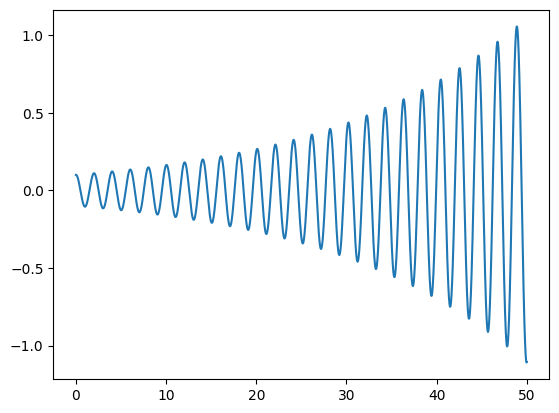

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x7ca3275c7b90>

In [7]:
x0 = [.1; 0]
x_hist1, t_hist1 = pendulum_forward_euler(pendulum_dynamics, x0, 50, .01)
plot(t_hist1, x_hist1[1,:])

In [8]:
function pendulum_euler_Ad(x0, h)
    g = 9.81
    Ad = [1 h; -g*h*cos(x0[1]) 1]
end

pendulum_euler_Ad (generic function with 1 method)

In [9]:
eigvals(pendulum_euler_Ad(0, 0.001))

2-element Vector{ComplexF64}:
 1.0 - 0.0031320919526731652im
 1.0 + 0.0031320919526731652im

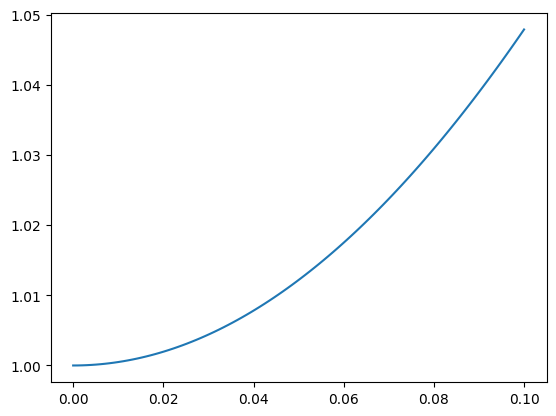

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x7ca32741e9c0>

In [10]:
eignorm = zeros(100)
h = LinRange(0,0.1,100)
for k = 1:length(eignorm)
    eignorm[k] = max(norm.(eigvals(pendulum_euler_Ad([0;0], h[k])))...)
end
plot(h,eignorm)

In [11]:
function fd_pendulum_rk4(xk, h)
    f1 = pendulum_dynamics(xk)
    f2 = pendulum_dynamics(xk + 0.5*h*f1)
    f3 = pendulum_dynamics(xk + 0.5*h*f2)
    f4 = pendulum_dynamics(xk + h*f3)
    return xk + (h/6.0)*(f1 + 2*f2 + 2*f3 + f4)
end

fd_pendulum_rk4 (generic function with 1 method)

In [12]:
function pendulum_rk4(fun, x0, Tf, h)    
    t = Array(range(0,Tf,step=h))
    
    x_hist = zeros(length(x0),length(t))
    x_hist[:,1] .= x0
    
    for k = 1:(length(t)-1)
        x_hist[:,k+1] .= fd_pendulum_rk4(x_hist[:,k], h)
    end
    
    return x_hist, t
end

pendulum_rk4 (generic function with 1 method)

In [ ]:
x0 = [.1; 0]
x_hist2, t_hist2 = pendulum_rk4(pendulum_dynamics, x0, 100, 0.01)
plot(t_hist2, x_hist2[1,:])

In [13]:
using ForwardDiff
Ad = ForwardDiff.jacobian(x -> fd_pendulum_rk4(x, 0.01), [0; 0])
norm.(eigvals(Ad))

2-element Vector{Float64}:
 0.9999999999934447
 0.9999999999934447

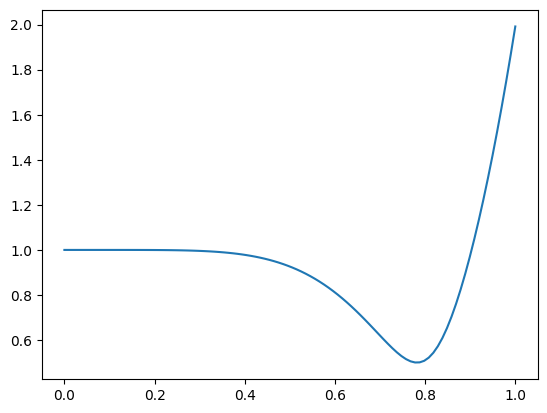

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x7ca349101ca0>

In [14]:
eignorm = zeros(100)
h = LinRange(0,1,100)
for k = 1:length(eignorm)
    eignorm[k] = max(norm.(eigvals(ForwardDiff.jacobian(x -> fd_pendulum_rk4(x, h[k]), [0; 0])))...)
end
plot(h,eignorm)

In [15]:
function pendulum_backward_euler(fun, x0, Tf, dt)
    t = Array(range(0,Tf,step=dt))
    
    x_hist = zeros(length(x0),length(t))
    x_hist[:,1] .= x0
    
    for k = 1:(length(t)-1)
        e = 1
        x_hist[:,k+1] = x_hist[:,k]
        while e > 1e-8
            xn = x_hist[:,k] + dt.*fun(x_hist[:,k+1])
            e = norm(xn - x_hist[:,k+1])
            x_hist[:,k+1] .= xn
        end
    end
    
    return x_hist, t
end

pendulum_backward_euler (generic function with 1 method)

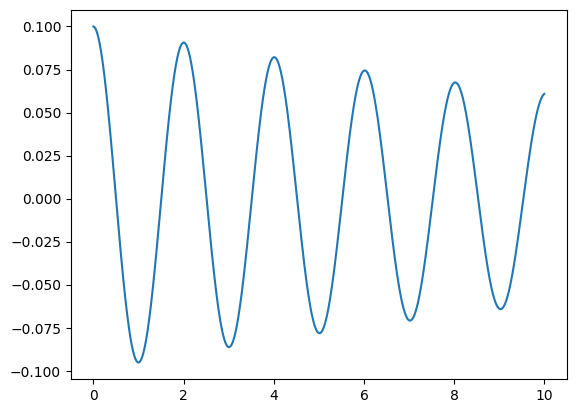

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x7ca349179f70>

In [16]:
x0 = [.1; 0]
x_hist3, t_hist3 = pendulum_backward_euler(pendulum_dynamics, x0, 10, 0.01)
plot(t_hist3, x_hist3[1,:])